In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
train_dir = "../dataset/train"
test_dir = "../dataset/test"

In [ ]:
# Configuration
MODE = "debug"  # "debug" | "dev" | "final"

PARAMS = {
    "debug": {"epochs": 3, "batch_size": 32, "img_size": 48, "color_mode": "grayscale", "data_percent": 0.1},
    "dev": {"epochs": 15, "batch_size": 64, "img_size": 48, "color_mode": "grayscale", "data_percent": 0.5},
    "final": {"epochs": 40, "batch_size": 64, "img_size": 48, "color_mode": "grayscale", "data_percent": 1.0}
}

CFG = PARAMS[MODE]
EPOCHS, BATCH_SIZE, IMG_SIZE, COLOR_MODE, DATA_PERCENT = CFG.values()
SAVE_NAME = f'model_{MODE}.keras'

print(f"MODE: {MODE} | Epochs: {EPOCHS} | Batch: {BATCH_SIZE} | Data: {DATA_PERCENT*100:.0f}%")


== MODE: debug ==
Epochs: 3 | Batch: 32 | Images: 10%
Model saved as: model_debug_debug.keras


In [ ]:
import math

# Data generators
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE, class_mode="categorical", shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE, class_mode="categorical", shuffle=False
)

# Limiter le pourcentage d’images
if DATA_PERCENT < 1.0:
    for gen in [train_generator, validation_generator]:
        gen.samples = gen.n = math.ceil(gen.samples * DATA_PERCENT)
        gen._set_index_array()
    print(f"Mode {MODE}: {DATA_PERCENT*100:.0f}% des données utilisées")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
⚠️ MODE debug: 10% des images
 - Train: 2871/28709
 - Val:   718/7178


In [ ]:
# Labels des émotions
LABELS = sorted(train_generator.class_indices.keys())
label_dict = {i: label for i, label in enumerate(LABELS)}
print(f"Classes: {LABELS}")


In [ ]:
# Construction du modèle
channels = 1 if COLOR_MODE == "grayscale" else 3
input_shape = (IMG_SIZE, IMG_SIZE, channels)
num_classes = train_generator.num_classes

def build_model(mode, input_shape, num_classes):
    model = Sequential()
    
    if mode == "debug":
        model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPool2D(2))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(2))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        
    elif mode == "dev":
        model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
    else:  # final
        model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
    
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(MODE, input_shape, num_classes)
model.summary()


In [ ]:
# Entraînement
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

model.save(SAVE_NAME)
print(f"✅ Modèle sauvegardé: {SAVE_NAME}")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,159 (2.32 MB)

 Trainable params: 609,159 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.9735 - loss: 0.2506 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/3
 7/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 1.0000 - loss: 4.7810e-04

KeyboardInterrupt: 

In [ ]:
# Visualisation de l'entraînement
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Évaluation
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
print(f"Train accuracy: {train_acc*100:.2f}% | Validation accuracy: {val_acc*100:.2f}%")


In [ ]:
# Fonction de prédiction
def predict_emotion(img_path):
    """Prédit l'émotion d'une image"""
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode=COLOR_MODE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_array, verbose=0)[0]
    class_idx = int(np.argmax(preds))
    confidence = float(preds[class_idx])
    emotion = label_dict[class_idx]
    
    plt.imshow(img, cmap="gray" if COLOR_MODE == "grayscale" else None)
    plt.axis("off")
    plt.title(f"{emotion} ({confidence*100:.2f}%)")
    plt.show()
    
    print(f"Émotion: {emotion} | Confiance: {confidence*100:.2f}%")
    return emotion, confidence

# Exemple d'utilisation
# predict_emotion("../dataset/test/happy/im1021.png")


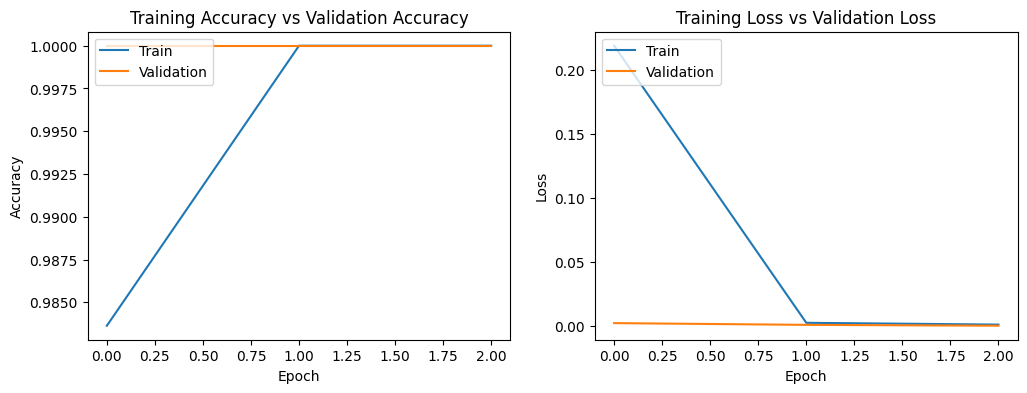

In [ ]:
# Test de prédiction sur une image
img_path = "../dataset/test/happy/im1021.png"
predict_emotion(img_path)

In [ ]:
# Charger un modèle sauvegardé (si nécessaire)
if not 'model' in locals():
    if Path(SAVE_NAME).exists():
        model = load_model(SAVE_NAME)
        print(f"✅ Modèle chargé: {SAVE_NAME}")
    else:
        print(f"⚠️ Modèle non trouvé: {SAVE_NAME}")


final train accuracy = 100.00 , validation accuracy = 100.00


(48, 48)


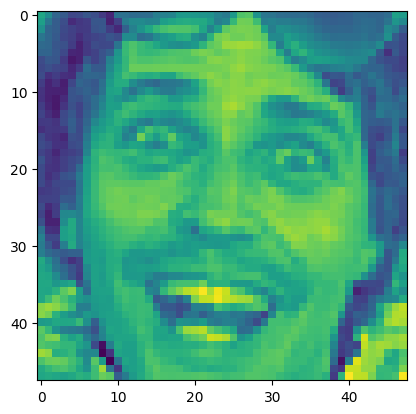

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[np.float32(1.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]


Angry


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 1.0000 - loss: 6.9424e-04
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 4.9793e-04
final train accuracy = 100.00 , validation accuracy = 100.00
